...............Reading the Dataset and Dataset Pre-Processing................
Time Cost for Pre-processing and Reading the Dataset: 0.177104 seconds

............... Initializing hyperparameters and Architecture Grid ................
Architecture: [6]
Optimized Architecture: [278]
Architecture: [10]
Optimized Architecture: [278]
Architecture: [8, 6]
Optimized Architecture: [278]
Architecture: [12, 12, 6]
Optimized Architecture: [278]
............... Results ................
Optimized Architecture    Optimized RMSE  Optimized R²    Optimized VAF   Optimized MAE  
[278]                     0.0512 0.6416 64.5144 2.6218
[278]                     0.0512 0.6416 64.5144 2.6218
[278]                     0.0512 0.6416 64.5144 2.6218
[278]                     0.0512 0.6416 64.5144 2.6218

Best Optimized Architecture: [278]


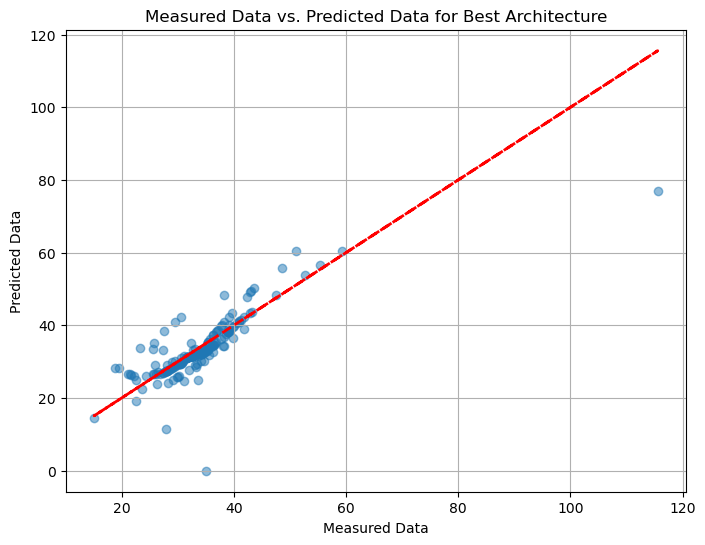

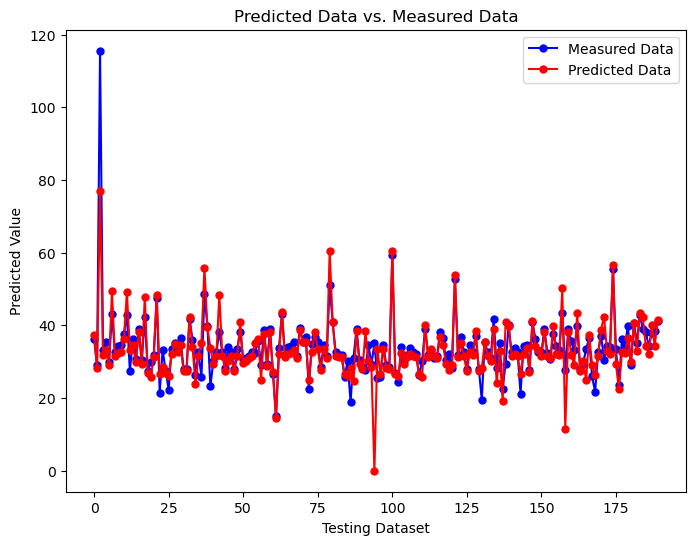

In [1]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn import preprocessing as pre
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

# Function to train and evaluate the neural network with a given architecture
def train_and_evaluate_network(architecture, x_train, y_train, x_test, y_test):
    # ReLU Activation function
    def relu(x):
        return np.maximum(0, x)

    # Derivative of ReLU
    def derivative_relu(x):
        return (x > 0).astype(int)

    # Initialize weights
    np.random.seed(39)
    inp = x_train.shape[1]
    out = 1
    weights = []
    for i in range(len(architecture)):
        if i == 0:
            weights.append(np.random.randn(inp, architecture[i]))
        else:
            weights.append(np.random.randn(architecture[i-1], architecture[i]))
    weights.append(np.random.randn(architecture[-1], out))

    rmse_list = []
    r2_list = []
    vaf_list = []
    mae_list = []
    epochs = 500
    eta = 0.0001
    alpha = 0.7
    best_rmse = float('inf')
    best_weights = None

    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)  # Split training set into train and validation sets

    for epoch in range(epochs):
        # Feedforward for hidden layers by calling activation function
        layer_outs = []
        layer_outs.append(relu(np.dot(x_train, weights[0])))
        for i in range(1, len(architecture)):
            layer_outs.append(relu(np.dot(layer_outs[i-1], weights[i])))

        output = np.dot(layer_outs[-1], weights[-1])
        final_out = relu(output)

        rmse = np.sqrt(np.mean(np.square(final_out - y_train))) / 100
        rmse_list.append(rmse)

        # Early stopping if RMSE on validation set starts to increase
        val_output = np.dot(relu(np.dot(x_val, weights[0])), weights[1])
        val_final_out = relu(val_output)
        val_rmse = np.sqrt(np.mean(np.square(val_final_out - y_val))) / 100
        if val_rmse < best_rmse:
            best_rmse = val_rmse
            best_weights = weights.copy()
        else:
            # Restore the best weights and stop training
            weights = best_weights
            break

        # Calculate R²
        ssr = np.sum((y_train - final_out) ** 2)
        sst = np.sum((y_train - np.mean(y_train)) ** 2)
        r2 = 1 - (ssr / sst)
        r2_list.append(r2)

        # Calculate VAF
        vaf = (1 - (np.var(y_train - final_out) / np.var(y_train))) * 100
        vaf_list.append(vaf)

        # Calculate MAE
        mae = np.mean(np.abs(y_train - final_out))
        mae_list.append(mae)

        # Backpropagation for hidden layers
        final_err = final_out - y_train
        final_relu_derivative = derivative_relu(final_out)

        errors = []
        errors.append(np.dot(final_err * final_relu_derivative, weights[-1].T))
        derivatives = []
        derivatives.append(errors[0] * derivative_relu(layer_outs[-1]))

        for i in range(len(architecture) - 2, -1, -1):
            errors.insert(0, np.dot(derivatives[0], weights[i+1].T))
            derivatives.insert(0, errors[0] * derivative_relu(layer_outs[i]))

        # Update weights
        for i in range(len(architecture)):
            if i == 0:
                weights[i] -= eta * alpha * np.dot(x_train.T, derivatives[i]) / y_train.size
            else:
                weights[i] -= eta * alpha * np.dot(layer_outs[i-1].T, derivatives[i]) / y_train.size
        weights[-1] -= eta * alpha * np.dot(layer_outs[-1].T, final_err * final_relu_derivative) / y_train.size

    # Testing
    layer_outs_test = []
    layer_outs_test.append(relu(np.dot(x_test, weights[0])))
    for i in range(1, len(architecture)):
        layer_outs_test.append(relu(np.dot(layer_outs_test[i-1], weights[i])))

    output_test = np.dot(layer_outs_test[-1], weights[-1])
    final_out_test = relu(output_test)

    # Calculate RMSE
    rmse_test = np.sqrt(np.mean(np.square(final_out_test - y_test))) / 100

    # Calculate R² for test set
    ssr_test = np.sum((y_test - final_out_test) ** 2)
    sst_test = np.sum((y_test - np.mean(y_test)) ** 2)
    r2_test = 1 - (ssr_test / sst_test)

    # Calculate VAF for test set
    vaf_test = (1 - (np.var(y_test - final_out_test) / np.var(y_test))) * 100

    # Calculate MAE for test set
    mae_test = np.mean(np.abs(y_test - final_out_test))

    return rmse_test, r2_test, vaf_test, mae_test, final_out_test

# Read and preprocess the dataset
print("...............Reading the Dataset and Dataset Pre-Processing................")
start_time = time.time()
dataset = shuffle(pd.read_csv("blast_dataset1.csv"))

x = dataset[["B", "S", "H", "D", "TI", "TF", "L", "C", "PF", "RF"]]
y = dataset[["X"]]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# Normalizing data using Standard Scaler Fit Transform
scaler = pre.StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Converting pd dataframe to numpy array to match compatibility
y_train = y_train.astype(float).to_numpy()
y_test = y_test.astype(float).to_numpy()

end_time = time.time()
total_time = end_time - start_time
print("Time Cost for Pre-processing and Reading the Dataset: %f seconds\n" % total_time)

print("............... Initializing hyperparameters and Architecture Grid ................")
start_time = time.time()
# Setting Hyperparameters
architectures = [
    [6],
    [10],
    [8, 6],
    [12, 12, 6],
]  # List of architectures to try

results = []

# PSO parameters
num_particles = 50
num_dimensions = len(architectures[0])
max_iterations = 40

# Define the PSO algorithm
def pso(objective_function, num_particles, num_dimensions, max_iterations):
    # PSO parameters
    W = 0.5  # inertia weight
    c1 = 2.0  # cognitive weight
    c2 = 2.0  # social weight

    # Initialize particles and velocities
    particles = np.random.uniform(low=1, high=20, size=(num_particles, num_dimensions))
    velocities = np.zeros((num_particles, num_dimensions))
    best_positions = particles.copy()
    best_scores = np.full(num_particles, -np.inf)
    global_best_position = None
    global_best_score = -np.inf

    # PSO main loop
    for _ in range(max_iterations):
        # Evaluate current particle positions
        scores = np.array([objective_function(p) for p in particles])

        # Update personal best positions and scores
        improved_indices = scores > best_scores
        best_scores[improved_indices] = scores[improved_indices]
        best_positions[improved_indices] = particles[improved_indices]

        # Update global best position and score
        best_particle_index = np.argmax(best_scores)
        if best_scores[best_particle_index] > global_best_score:
            global_best_score = best_scores[best_particle_index]
            global_best_position = best_positions[best_particle_index]

        # Update particle velocities and positions
        r1 = np.random.random((num_particles, num_dimensions))
        r2 = np.random.random((num_particles, num_dimensions))
        velocities = (W * velocities) + (c1 * r1 * (best_positions - particles)) + (c2 * r2 * (global_best_position - particles))
        particles = particles + velocities

    return global_best_position, global_best_score

# Train and evaluate for each architecture using PSO optimization
best_architecture_results = []

for architecture in architectures:
    print("Architecture:", architecture)

    # Define the objective function for PSO optimization
    def objective_function(architecture):
        # Train and evaluate the BPNN using the architecture
        architecture = np.abs(architecture).astype(int)  # Convert to positive integer array
        rmse, r2, vaf, mae, _ = train_and_evaluate_network(architecture, x_train, y_train, x_test, y_test)
        return -rmse  # Negative RMSE for PSO maximization

    # Perform PSO optimization to find the best architecture
    best_architecture, optimized_rmse = pso(objective_function, num_particles, num_dimensions, max_iterations)
    best_architecture = np.abs(np.round(best_architecture).astype(int))  # Convert to positive rounded integer array
    print("Optimized Architecture:", best_architecture)

    # Get the best architecture's predictions and evaluate its performance
    optimized_rmse, optimized_r2, optimized_vaf, optimized_mae, best_architecture_predictions = train_and_evaluate_network(best_architecture, x_train, y_train, x_test, y_test)
    best_architecture_results.append((best_architecture, optimized_rmse, optimized_r2, optimized_vaf, optimized_mae))

# Sort the results based on the optimized RMSE
best_architecture_results.sort(key=lambda x: x[1])

print("............... Results ................")
# Print optimized results in tabular format
headers = ["Optimized Architecture", "Optimized RMSE", "Optimized R²", "Optimized VAF", "Optimized MAE"]
print("{:<25} {:<15} {:<15} {:<15} {:<15}".format(*headers))
for result in best_architecture_results:
    print("{:<25} {:.4f} {:.4f} {:.4f} {:.4f}".format(str(result[0]), result[1], result[2], result[3], result[4]))

# Get the best optimized architecture
best_architecture = best_architecture_results[0][0]
print("\nBest Optimized Architecture:", best_architecture)

# Get the best optimized architecture's predictions
_, _, _, _, best_architecture_predictions = train_and_evaluate_network(best_architecture, x_train, y_train, x_test, y_test)

# Plotting the graph of predicted data versus measured data for the best architecture
plt.figure(figsize=(8, 6))
plt.scatter(y_test, best_architecture_predictions, alpha=0.5)
plt.plot(y_test, y_test, color='red', linestyle='--', linewidth=2)
plt.xlabel("Measured Data")
plt.ylabel("Predicted Data")
plt.title("Measured Data vs. Predicted Data for Best Architecture")
plt.grid(True)
plt.show()

# Plotting the line graph of predicted data versus measured data for the best architecture
plt.figure(figsize=(8, 6))
plt.plot(y_test, label='Measured Data', color='blue', marker='o', linestyle='-', markersize=5)
plt.plot(best_architecture_predictions, label='Predicted Data', color='red', marker='o', linestyle='-', markersize=5)
plt.xlabel("Testing Dataset")
plt.ylabel("Predicted Value")
plt.title("Predicted Data vs. Measured Data")
plt.legend()
plt.show()
